## Engle-Granger Test

In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint

# === Load Data ===
# Adjust file paths if running locally
price_data = pd.read_csv("sp500_prices_cleaned.csv", index_col=0, parse_dates=True)
pair_list = pd.read_csv("high_corr_pairs.csv")

# === Transform prices ===
log_prices = np.log(price_data)

# === Cointegration test ===
results = []

for _, row in pair_list.iterrows():
    stock_a = row["Stock A"]
    stock_b = row["Stock B"]

    if stock_a in log_prices.columns and stock_b in log_prices.columns:
        series_a = log_prices[stock_a].dropna()
        series_b = log_prices[stock_b].dropna()

        # Align time series on date index
        aligned = pd.concat([series_a, series_b], axis=1).dropna()

        if len(aligned) < 100:
            continue  # Skip pairs with insufficient data

        # Run Engle-Granger test
        score, pvalue, _ = coint(aligned.iloc[:, 0], aligned.iloc[:, 1])

        results.append({
            "Stock A": stock_a,
            "Stock B": stock_b,
            "Correlation": row["Correlation"],
            "P-Value": pvalue,
            "Test Statistic": score
        })

# === Create and export results ===
coint_results = pd.DataFrame(results)
coint_results = coint_results.sort_values(by="P-Value").reset_index(drop=True)
significant_pairs = coint_results[coint_results["P-Value"] < 0.05].reset_index(drop=True)

# Display top cointegrated pairs
print("Top cointegrated pairs:")
print(significant_pairs.head(10))

# Optional: Save to CSV
# coint_results.to_csv("engle_granger_results.csv", index=False)

Top cointegrated pairs:
  Stock A Stock B  Correlation   P-Value  Test Statistic
0      MA       V     0.877510  0.001096       -4.529239
1     FRT     KIM     0.877778  0.011237       -3.860487
2     MCO    SPGI     0.850401  0.023546       -3.613933
3     AVB     ESS     0.892483  0.029258       -3.536939
4     DHI     LEN     0.932494  0.038401       -3.437031
5     LEN     PHM     0.912155  0.040760       -3.414550


## Johansen Test

In [7]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# === Run Johansen test ===
results = []

for _, row in pair_list.iterrows():
    stock_a, stock_b = row["Stock A"], row["Stock B"]
    
    if stock_a in log_prices.columns and stock_b in log_prices.columns:
        series_a = log_prices[stock_a].dropna()
        series_b = log_prices[stock_b].dropna()

        # Align on common dates
        aligned = pd.concat([series_a, series_b], axis=1).dropna()

        if len(aligned) < 100:
            continue

        try:
            # Johansen test with lag=1 and linear trend
            test_result = coint_johansen(aligned, det_order=0, k_ar_diff=1)
            
            trace_stat = test_result.lr1[0]        # Trace statistic for rank=0
            critical_val = test_result.cvt[0, 1]   # 5% critical value

            cointegrated = trace_stat > critical_val

            results.append({
                "Stock A": stock_a,
                "Stock B": stock_b,
                "Correlation": row["Correlation"],
                "Trace Stat (r=0)": trace_stat,
                "5% Crit Value": critical_val,
                "Cointegrated (Johansen)": cointegrated
            })
        except Exception as e:
            print(f"Error testing pair {stock_a}-{stock_b}: {e}")
            continue

# === Create result DataFrame ===
johansen_results = pd.DataFrame(results)
johansen_results = johansen_results.sort_values(by="Trace Stat (r=0)", ascending=False).reset_index(drop=True)

# === Show only pairs identified as cointegrated ===
johansen_cointegrated = johansen_results[johansen_results["Cointegrated (Johansen)"] == True]

print("Johansen-identified cointegrated pairs (trace stat > critical value @ 5%):")
print(johansen_cointegrated.head(10))

# Optional: Save results
# johansen_cointegrated.to_csv("johansen_cointegrated_pairs.csv", index=False)

Johansen-identified cointegrated pairs (trace stat > critical value @ 5%):
  Stock A Stock B  Correlation  Trace Stat (r=0)  5% Crit Value  \
0     COP     EOG     0.877293         24.339520        15.4943   
1     FRT     KIM     0.877778         19.909870        15.4943   
2     MCO    SPGI     0.850401         19.339885        15.4943   
3      MA       V     0.877510         17.354892        15.4943   
4     CMS     DTE     0.883519         16.712592        15.4943   
5     AEE     WEC     0.875669         16.512819        15.4943   
6     AVB     ESS     0.892483         16.056848        15.4943   
7      ED     WEC     0.858535         16.021369        15.4943   
8     HAL     SLB     0.856511         15.914872        15.4943   

   Cointegrated (Johansen)  
0                     True  
1                     True  
2                     True  
3                     True  
4                     True  
5                     True  
6                     True  
7                     

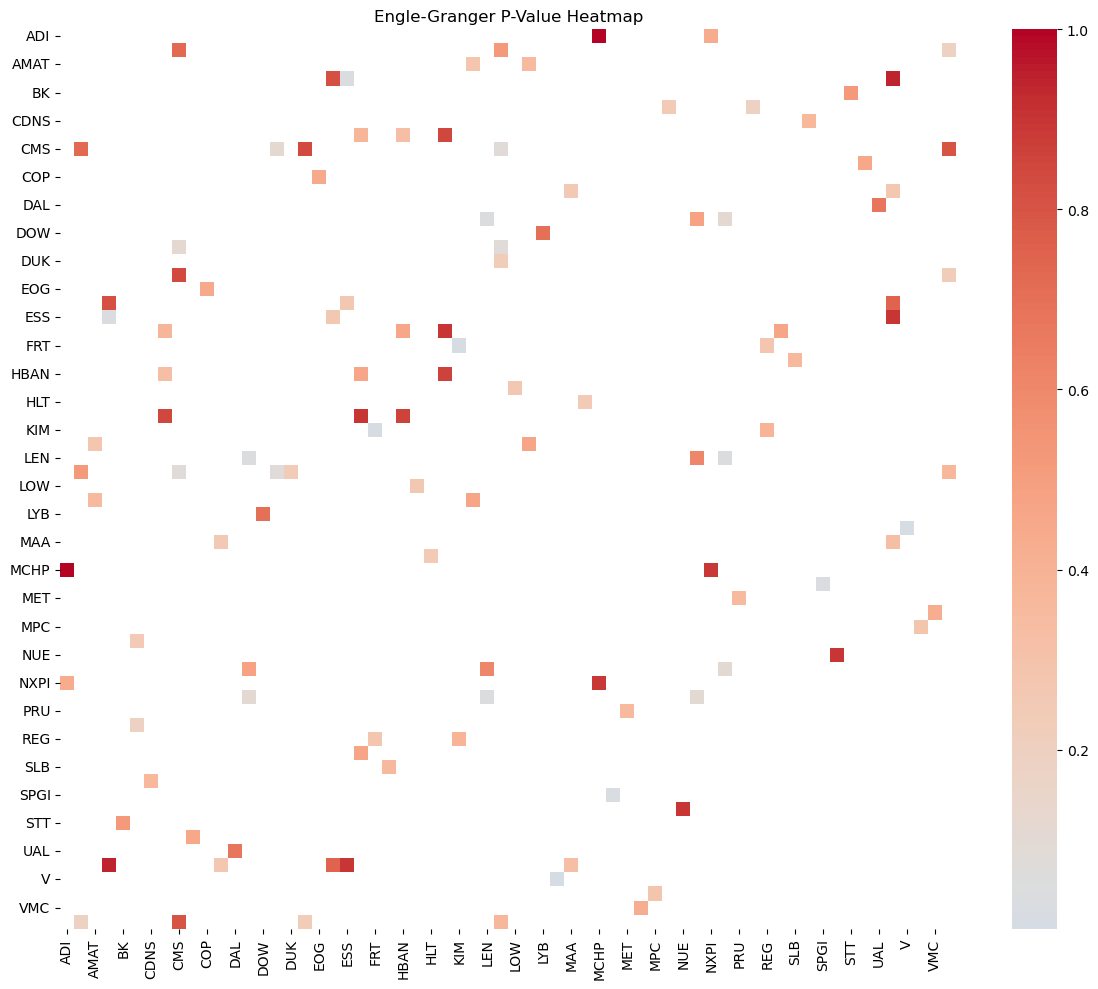

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# === 1. Engle-Granger P-Value Heatmap ===
# Construct symmetric matrix
engle_matrix = {}
for _, row in coint_results.iterrows():
    a, b, p = row["Stock A"], row["Stock B"], row["P-Value"]
    engle_matrix[(a, b)] = p
    engle_matrix[(b, a)] = p  # symmetric

tickers = sorted(set([t for pair in engle_matrix.keys() for t in pair]))
pval_matrix = pd.DataFrame(index=tickers, columns=tickers, dtype=float)

for (a, b), p in engle_matrix.items():
    pval_matrix.loc[a, b] = p

plt.figure(figsize=(12, 10))
sns.heatmap(pval_matrix, cmap="coolwarm", center=0.05)
plt.title("Engle-Granger P-Value Heatmap")
plt.tight_layout()
plt.show()

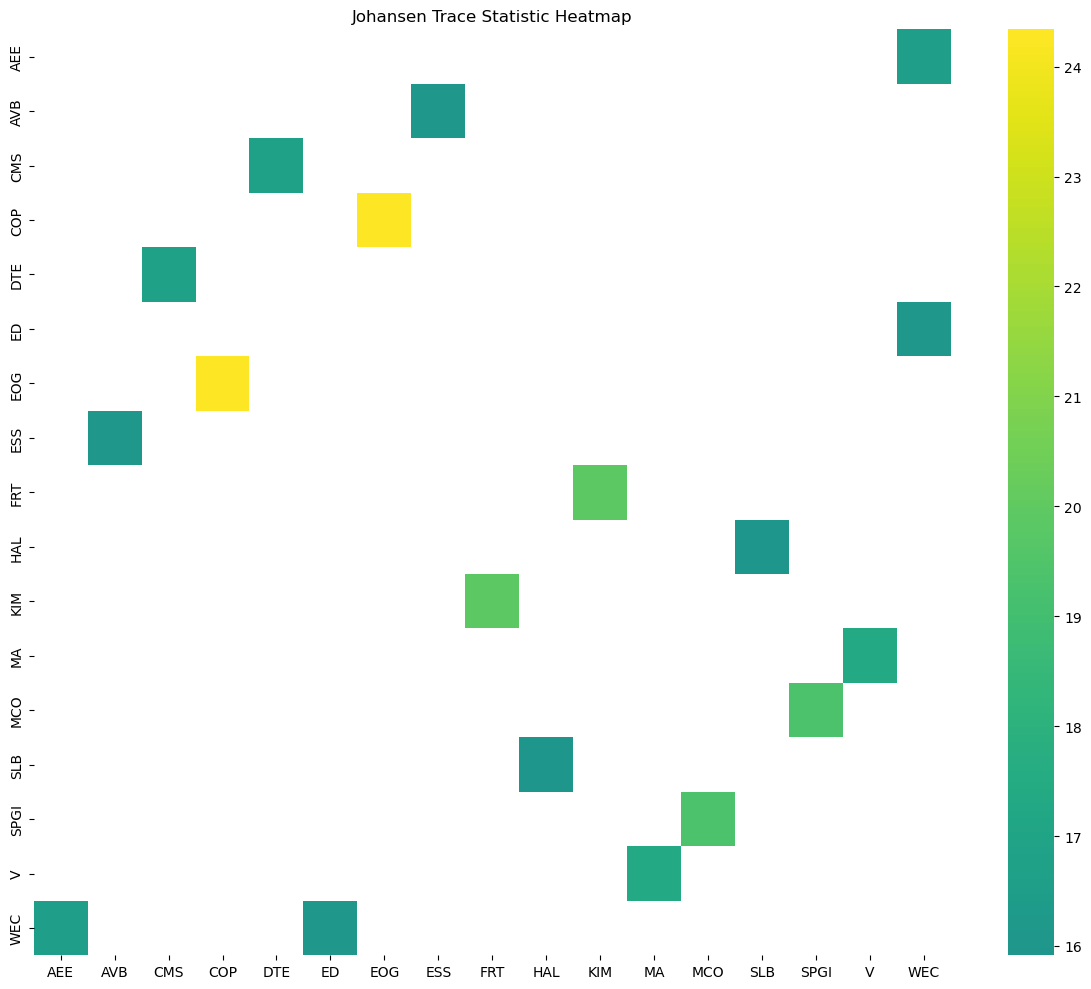

In [17]:
# === 2. Johansen Trace Stat Heatmap ===
j_matrix = {}
for _, row in johansen_cointegrated.iterrows():
    a, b, t = row["Stock A"], row["Stock B"], row["Trace Stat (r=0)"]
    j_matrix[(a, b)] = t
    j_matrix[(b, a)] = t  # symmetric

tickers_j = sorted(set([t for pair in j_matrix.keys() for t in pair]))
trace_matrix = pd.DataFrame(index=tickers_j, columns=tickers_j, dtype=float)

for (a, b), t in j_matrix.items():
    trace_matrix.loc[a, b] = t

plt.figure(figsize=(12, 10))
sns.heatmap(trace_matrix, cmap="viridis", center=johansen_cointegrated["5% Crit Value"].iloc[0])
plt.title("Johansen Trace Statistic Heatmap")
plt.tight_layout()
plt.show()

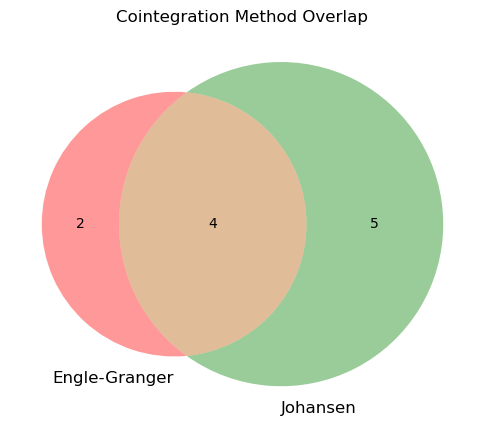

In [19]:
# === 3. Venn Diagram of Cointegrated Pairs ===
engle_pairs = set(tuple(sorted([row["Stock A"], row["Stock B"]])) 
                  for _, row in coint_results.iterrows() if row["P-Value"] < 0.05)

johansen_pairs = set(tuple(sorted([row["Stock A"], row["Stock B"]])) 
                     for _, row in johansen_cointegrated.iterrows())

plt.figure(figsize=(6, 6))
venn2([engle_pairs, johansen_pairs], set_labels=("Engle-Granger", "Johansen"))
plt.title("Cointegration Method Overlap")
plt.show()